In [1]:
import os
from tqdm.auto import tqdm

import s5cmdpy
import unibox as ub

## Initial attempt

In [4]:
v5c_path =  "/rmt/image_data/data_catalog/data_catalog/gold/dset_all_v5c.parquet"
v5c_df = ub.loads(v5c_path)

ub.peeks(v5c_df)

2024-07-29 19:34:08,461 [INFO] UniLogger: UniLoader.loads: .parquet LOADED from "/rmt/image_data/data_catalog/data_catalog/gold/dset_all_v5c.parquet" in 27.85s


(4688203, 34)
Index(['index_num', 'filename', 's3_uri', 'pixiv__pid', 'clip__clip_aesthetic',
       'pixiv__likeCount', 'pixiv__viewCount', 'pixiv__bookmarkCount',
       'pixiv__aiType', 'pixiv__compound_score', 'caption',
       'aigccls__aigc_pred', 'aigccls__is_likely-ai', 'dset__pixels',
       'dset__from', 'danbooru_id', 'danbooru__up_score',
       'danbooru__down_score', 'danbooru__fav_count', 'danbooru__is_banned',
       'danbooru__tag_string_artist', 'danbooru__tag_string_character',
       'clip__twitter_aesthetic_v2', 'comps__comp_score_pred',
       'resized__resized_s3_uri', 'clip_aesthetic_2_5',
       'danbooru__quality_tag', 'twitter__favorite_count', 'twitter__hashtags',
       'twitter__compound_score', 'twitter__quality_tag', 'dset__quality_tag',
       'dset__artist_occurence_count', 'dset__row_cap_dict'],
      dtype='object')


,index_num,filename,s3_uri,pixiv__pid,clip__clip_aesthetic,pixiv__likeCount,pixiv__viewCount,pixiv__bookmarkCount,pixiv__aiType,pixiv__compound_score,...,resized__resized_s3_uri,clip_aesthetic_2_5,danbooru__quality_tag,twitter__favorite_count,twitter__hashtags,twitter__compound_score,twitter__quality_tag,dset__quality_tag,dset__artist_occurence_count,dset__row_cap_dict
0,25,85967624_p0.jpg,s3://dataset-pixiv/artworks/85967624/85967624_...,85967624,5.76800,667.0,5547.0,981.0,0.0,11.154647,...,<NA>,NaN,None,NaN,None,NaN,None,average quality,1722743,None
1,56,85967667_p0.jpg,s3://dataset-pixiv/artworks/85967667/85967667_...,85967667,6.38851,3972.0,33782.0,6720.0,0.0,13.333247,...,s3://unidataset-danbooru/resized_1310720/image...,6.234648,average quality,NaN,None,NaN,None,good quality,105,None
2,93,85967719_p0.jpg,s3://dataset-pixiv/artworks/85967719/85967719_...,85967719,6.14013,589.0,5614.0,949.0,0.0,12.345294,...,<NA>,NaN,None,NaN,None,NaN,None,average quality,1722743,None


In [48]:
v5c_df["dset__quality_tag"].value_counts()

dset__quality_tag
average quality    2768587
good quality       1353090
bad quality         341060
best quality        162238
worst quality        63228
Name: count, dtype: int64

In [44]:
# v5c_better_df = v5c_df[v5c_df["dset__quality_tag"].isin(["good quality", "best quality"])]
v5c_better_df = v5c_df[v5c_df["dset__quality_tag"].isin(["best quality"])]

len(v5c_better_df)

162238

get images from all other categories:

In [49]:
import pandas as pd

all_sampled_dfs = []
all_new_uris = []


sample_config = [
    ("good quality", 160000),
    ("average quality", 80000),
    ("bad quality", 40000),
    ("worst quality", 20000),
]


for quality, sample_count in sample_config:
    df_slice = v5c_df[v5c_df["dset__quality_tag"] == quality]

    sampled_df_slice = df_slice.sample(n=sample_count, random_state=114514)
    
    all_sampled_dfs.append(sampled_df_slice)

all_sampled_df = pd.concat(all_sampled_dfs)

In [36]:
# sample_imgs = v5c_better_df.sample(1000)
# sample_uris = sample_imgs["s3_uri"].tolist()
# ub.peeks(sample_uris)

{'metadata': {'len': 1000, 'item_type': 'str'},
 'preview': ['s3://dataset-pixiv/artworks/99852212/99852212_p0.jpg',
  's3://dataset-pixiv/artworks/102049768/102049768_p0.jpg',
  's3://unidataset-danbooru/images/image_7314290/image_7314290.jpg']}

In [16]:
# sample_imgs = v5c_better_df
# sample_uris = sample_imgs["s3_uri"].tolist()
# ub.peeks(sample_uris)

{'metadata': {'len': 162238, 'item_type': 'str'},
 'preview': ['s3://dataset-pixiv/artworks/85968224/85968224_p0.jpg',
  's3://dataset-pixiv/artworks/85968225/85968225_p0.jpg',
  's3://dataset-pixiv/artworks/85968241/85968241_p0.png']}

In [50]:
sample_imgs = all_sampled_df
sample_uris = sample_imgs["s3_uri"].tolist()
ub.peeks(sample_uris)

{'metadata': {'len': 300000, 'item_type': 'str'},
 'preview': ['s3://dataset-pixiv/artworks/100410543/100410543_p0.jpg',
  's3://dataset-pixiv/artworks/91461512/91461512_p0.jpg',
  's3://dataset-pixiv/artworks/91867162/91867162_p0.jpg']}

test dataset:
- best quality (162k)
- good / avg / bad / worst (5k each)

In [51]:
# IMG_ROOT_DIR = "/lv0/kohya_datasets"

# curr_img_dir = "small_test_1k"
# _curr_img_dir = f"{IMG_ROOT_DIR}/{curr_img_dir}"
# os.makedirs(_curr_img_dir, exist_ok=True)


# subdir_name = "1"
# _subdir_name = f"{_curr_img_dir}/{subdir_name}"
# os.makedirs(_subdir_name, exist_ok=True)


# s5cmdpy.download_from_s3_list(sample_uris, _subdir_name)

[interval=5] running s5cmd:   0%|          | 0/300000 [00:00<?, ?it/s]

Loading batches:   0%|          | 0/20 [00:00<?, ?it/s]


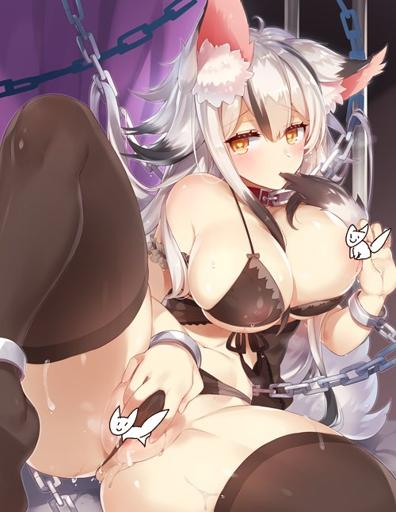
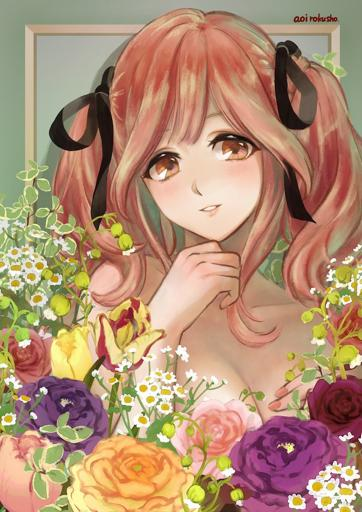
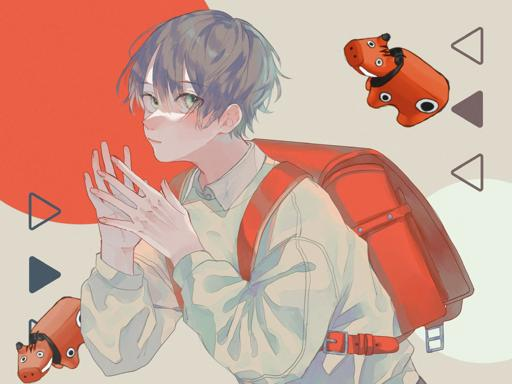
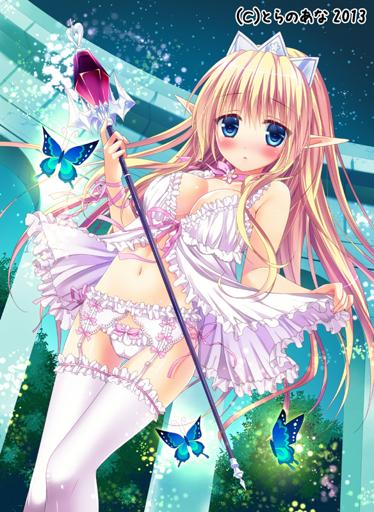
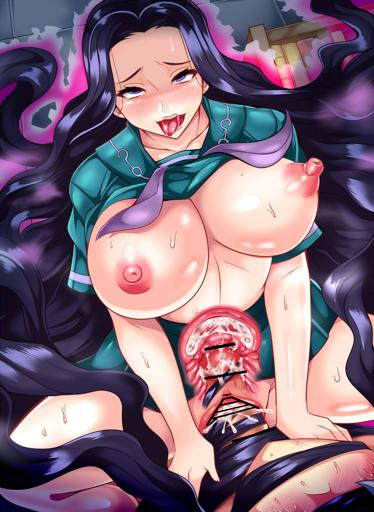
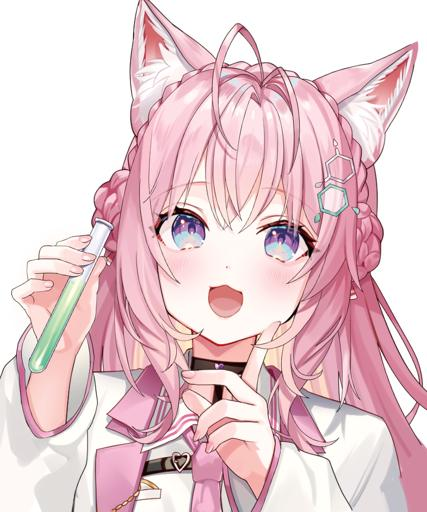
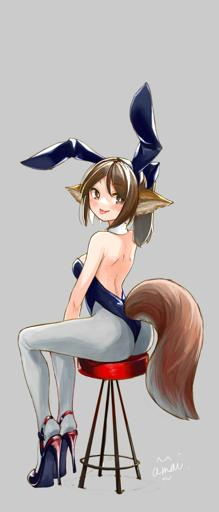
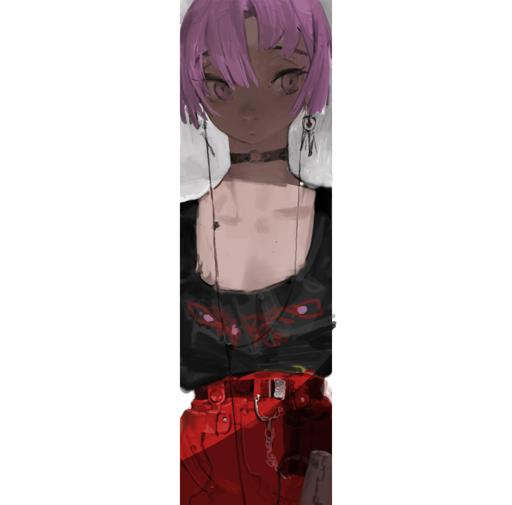
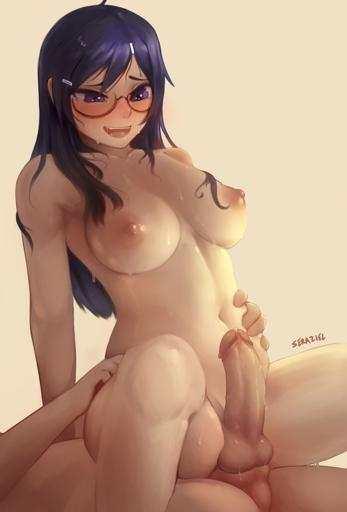
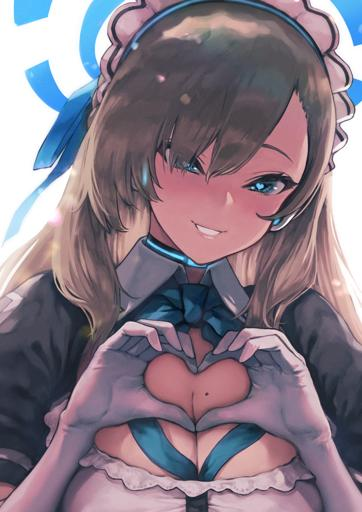
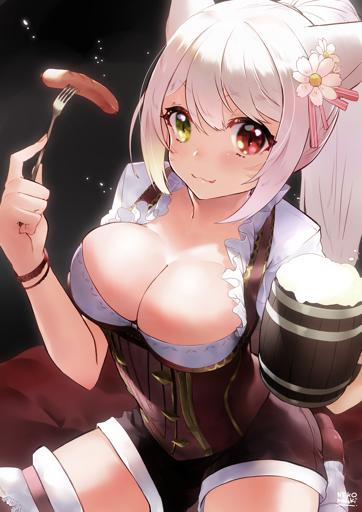
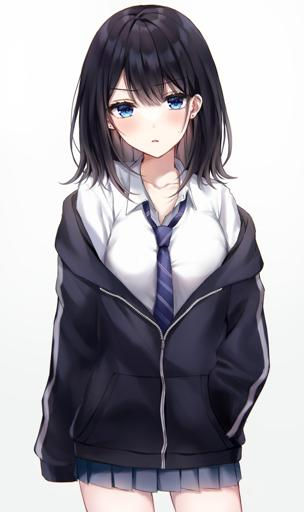
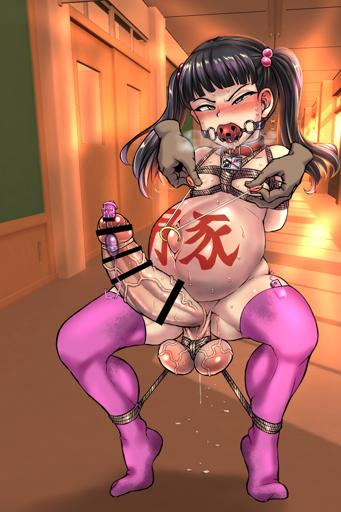
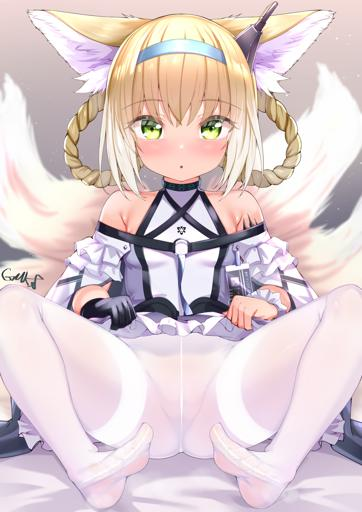
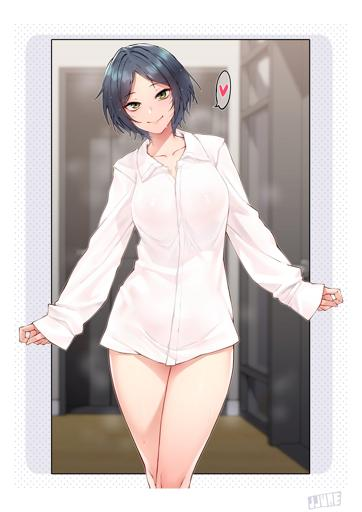
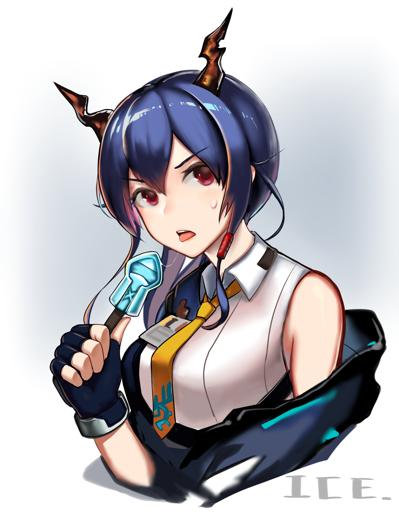
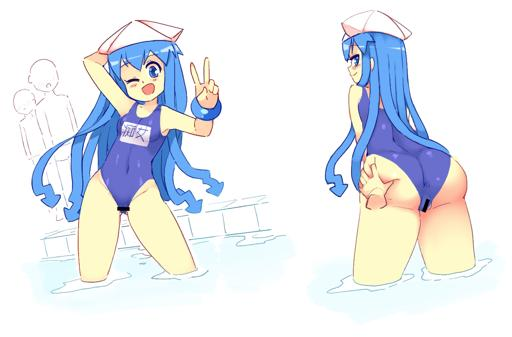
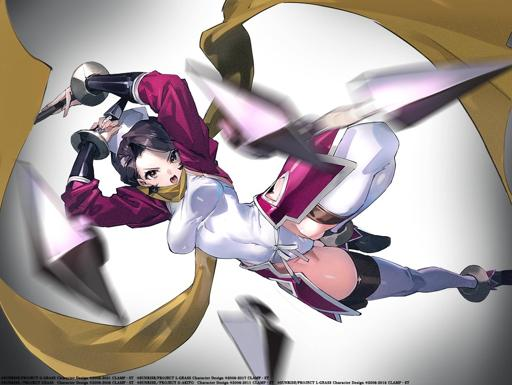
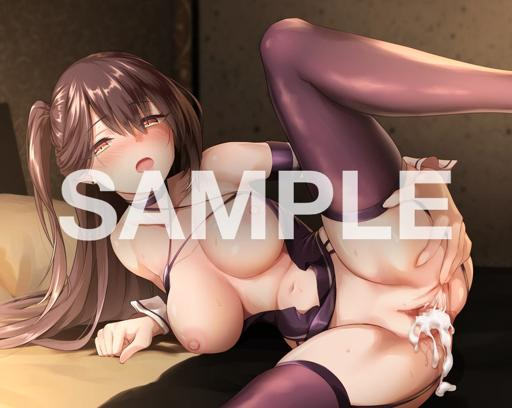
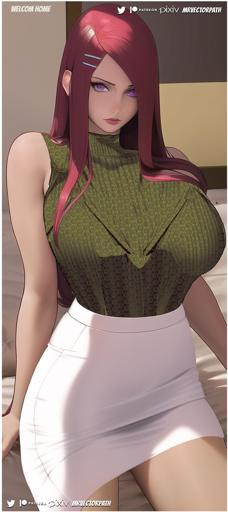

In [52]:
import random

random_uris = random.choices(sample_uris, k=20)

ub.gallery(random_uris)

In [53]:
!ls -l {_subdir_name} | wc -l

675877


In [54]:
_subdir_name

'/lv0/kohya_datasets/small_test_1k/1'

In [34]:
from dataproc4.utils.string_utils import safe_concat, safe_split_tag_string

def cap_dict_to_str_temp_character(cap_dict):
    """把一个dataproc4格式的caption dict转换成临时ft用的txt
    """
    tff = cap_dict.get("tags_front_fixed", "")  # artist
    tf = cap_dict.get("tags_front", "")         # character
    tm = cap_dict.get("tags_mid", "")           # general
    tm_alt = cap_dict.get("alternate_tags_mid", "")  # natural language
    tb = cap_dict.get("tags_back", "")          # quality

    tm_alt = tm_alt[0] if len(tm_alt) > 0 else ""

    tm_tags = safe_split_tag_string(tm)
    # max_tags = min(55, len(tm_tags))
    # sample_size = random.randint(5, max_tags) if len(tm_tags) >= 5 else len(tm_tags)
    # tm_tags = random.sample(tm_tags, sample_size)
    
    return safe_concat([tf], tm_tags, [tm_alt, tb])   # do not add artist tag

def write_captions_to_txt(cap_dict, output_dir):
    for k, v in tqdm(cap_dict.items(), desc=f"saving txt files to {output_dir}"):
        txt_content = cap_dict_to_str_temp_character(v)
        if not txt_content:
            print("NO CAPTION: ", k)
        txt_filename = os.path.join(output_dir, f"{k.split('.')[0]}.txt")

        os.makedirs(output_dir, exist_ok=True)
        ub.saves(txt_content, txt_filename, debug_print=False)

        
# img_files = ub.traverses(_subdir_name, ub.IMG_FILES)

# create a txt for each img file
file_cap_dict = sample_imgs[["filename", "caption"]].set_index("filename").to_dict()["caption"]
# write_captions_to_txt(file_cap_dict, _subdir_name)

saving txt files to /lv0/kohya_datasets/small_test_1k/1:   0%|          | 0/20000 [00:00<?, ?it/s]

In [37]:
file_cap_dict = sample_imgs[["filename", "caption"]].set_index("filename").to_dict()["caption"]

In [42]:
def get_txt_caps(cap_dict, output_dir):
    
    caps = {}
    for k, v in tqdm(cap_dict.items(), desc=f"saving txt files to {output_dir}"):
        txt_content = cap_dict_to_str_temp_character(v)
        if not txt_content:
            print("NO CAPTION: ", k)
        caps[k] = txt_content
    
    return caps

caps = get_txt_caps(file_cap_dict, _subdir_name)
ub.saves(caps, "run2_164_best_txt_caps.json")

saving txt files to /lv0/kohya_datasets/small_test_1k/1:   0%|          | 0/1000 [00:00<?, ?it/s]

2024-07-30 00:34:53,463 [INFO] UniLogger: UniSaver.saves: dict saved successfully to "run2_164_best_txt_caps.json"


In [11]:
txts = ub.traverses("/lv0/kohya_datasets/small_test_1k/1", [".txt"])
txts_content = ub.concurrent_loads(txts)

for txt in txts_content:
    if not txt:
        print("EMPTY")

Loading batches:   0%|          | 0/1000 [00:00<?, ?it/s]

In [14]:
imgs = ub.traverses("/lv0/kohya_model_outs/sample", ub.IMG_FILES)
imgs


[]

In [ ]:
/root/miniconda3/envs/hydit-kohya/bin/accelerate launch --dynamo_backend no --dynamo_mode default --mixed_precision fp16 --multi_gpu --num_processes 4 --num_machines 1 --num_cpu_threads_per_process 2 /lv0/kohya_ss_hydit/sd-scripts/hunyuan_train.py --config_file 

In [ ]:
# python ./sd-scripts/hunyuan_inference_gui.py


# /lv0/kohya_ss_hydit/models/HunyuanDiT-V1.2/t2i
# /lv0/kohya_model_outs/run2/last-step00001000.ckpt 

## Rearrange: 

已经有图, 用unibox resize过了

todo: 重新创建captions

In [2]:
import re
import os
from tqdm.auto import tqdm

import s5cmdpy
import unibox as ub

In [3]:
v5c_path =  "/rmt/image_data/data_catalog/data_catalog/gold/dset_all_v5c.parquet"
v5c_df = ub.loads(v5c_path)
ub.peeks(v5c_df)

2024-08-01 21:40:42,679 [INFO] UniLogger: UniLoader.loads: .parquet LOADED from "/rmt/image_data/data_catalog/data_catalog/gold/dset_all_v5c.parquet" in 28.31s


(4688203, 34)
Index(['index_num', 'filename', 's3_uri', 'pixiv__pid', 'clip__clip_aesthetic',
       'pixiv__likeCount', 'pixiv__viewCount', 'pixiv__bookmarkCount',
       'pixiv__aiType', 'pixiv__compound_score', 'caption',
       'aigccls__aigc_pred', 'aigccls__is_likely-ai', 'dset__pixels',
       'dset__from', 'danbooru_id', 'danbooru__up_score',
       'danbooru__down_score', 'danbooru__fav_count', 'danbooru__is_banned',
       'danbooru__tag_string_artist', 'danbooru__tag_string_character',
       'clip__twitter_aesthetic_v2', 'comps__comp_score_pred',
       'resized__resized_s3_uri', 'clip_aesthetic_2_5',
       'danbooru__quality_tag', 'twitter__favorite_count', 'twitter__hashtags',
       'twitter__compound_score', 'twitter__quality_tag', 'dset__quality_tag',
       'dset__artist_occurence_count', 'dset__row_cap_dict'],
      dtype='object')


,index_num,filename,s3_uri,pixiv__pid,clip__clip_aesthetic,pixiv__likeCount,pixiv__viewCount,pixiv__bookmarkCount,pixiv__aiType,pixiv__compound_score,...,resized__resized_s3_uri,clip_aesthetic_2_5,danbooru__quality_tag,twitter__favorite_count,twitter__hashtags,twitter__compound_score,twitter__quality_tag,dset__quality_tag,dset__artist_occurence_count,dset__row_cap_dict
0,25,85967624_p0.jpg,s3://dataset-pixiv/artworks/85967624/85967624_...,85967624,5.76800,667.0,5547.0,981.0,0.0,11.154647,...,<NA>,NaN,None,NaN,None,NaN,None,average quality,1722743,None
1,56,85967667_p0.jpg,s3://dataset-pixiv/artworks/85967667/85967667_...,85967667,6.38851,3972.0,33782.0,6720.0,0.0,13.333247,...,s3://unidataset-danbooru/resized_1310720/image...,6.234648,average quality,NaN,None,NaN,None,good quality,105,None
2,93,85967719_p0.jpg,s3://dataset-pixiv/artworks/85967719/85967719_...,85967719,6.14013,589.0,5614.0,949.0,0.0,12.345294,...,<NA>,NaN,None,NaN,None,NaN,None,average quality,1722743,None


In [4]:
# 85967624_p0.jpg -> 85967624_p0_resized.webp
v5c_df["resized_filename"] = v5c_df["filename"].apply(lambda x: re.sub(r'\.[^.]+$', '', x) + '_resized.webp')
v5c_df["resized_filename"].head()

0    85967624_p0_resized.webp
1    85967667_p0_resized.webp
2    85967719_p0_resized.webp
3    85967735_p0_resized.webp
4    85967738_p0_resized.webp
Name: resized_filename, dtype: object

得到只含文件夹里已有图片的df:

In [5]:
IMGS_DIR = "/lv0/kohya_datasets/v5c_mini_500k_resized_1572864/1"

imgs = ub.traverses(IMGS_DIR, ub.IMG_FILES, relative_unix=True)
ub.peeks(imgs)

{'metadata': {'len': 492729, 'item_type': 'str'},
 'preview': ['image_7137458_resized.webp',
  '1744326324511178811_1_resized.webp',
  '1518885093359587329_1_resized.webp']}

In [6]:
# filtered
dff = v5c_df[v5c_df["resized_filename"].isin(imgs)]
ub.peeks(dff)

(492729, 35)
Index(['index_num', 'filename', 's3_uri', 'pixiv__pid', 'clip__clip_aesthetic',
       'pixiv__likeCount', 'pixiv__viewCount', 'pixiv__bookmarkCount',
       'pixiv__aiType', 'pixiv__compound_score', 'caption',
       'aigccls__aigc_pred', 'aigccls__is_likely-ai', 'dset__pixels',
       'dset__from', 'danbooru_id', 'danbooru__up_score',
       'danbooru__down_score', 'danbooru__fav_count', 'danbooru__is_banned',
       'danbooru__tag_string_artist', 'danbooru__tag_string_character',
       'clip__twitter_aesthetic_v2', 'comps__comp_score_pred',
       'resized__resized_s3_uri', 'clip_aesthetic_2_5',
       'danbooru__quality_tag', 'twitter__favorite_count', 'twitter__hashtags',
       'twitter__compound_score', 'twitter__quality_tag', 'dset__quality_tag',
       'dset__artist_occurence_count', 'dset__row_cap_dict',
       'resized_filename'],
      dtype='object')


,index_num,filename,s3_uri,pixiv__pid,clip__clip_aesthetic,pixiv__likeCount,pixiv__viewCount,pixiv__bookmarkCount,pixiv__aiType,pixiv__compound_score,...,clip_aesthetic_2_5,danbooru__quality_tag,twitter__favorite_count,twitter__hashtags,twitter__compound_score,twitter__quality_tag,dset__quality_tag,dset__artist_occurence_count,dset__row_cap_dict,resized_filename
30,454,85968224_p0.jpg,s3://dataset-pixiv/artworks/85968224/85968224_...,85968224,6.75644,3416.0,27718.0,5077.0,0.0,14.073531,...,6.453920,good quality,13992.0,くろバニー,7.241091,best quality,best quality,857,None,85968224_p0_resized.webp
31,455,85968225_p0.jpg,s3://dataset-pixiv/artworks/85968225/85968225_...,85968225,6.34461,25627.0,316012.0,45139.0,0.0,14.207410,...,6.147826,good quality,48856.0,,6.878710,best quality,best quality,204,None,85968225_p0_resized.webp
35,470,85968241_p0.png,s3://dataset-pixiv/artworks/85968241/85968241_...,85968241,7.24312,4979.0,36283.0,7339.0,0.0,15.072472,...,NaN,None,NaN,None,NaN,None,best quality,1722743,None,85968241_p0_resized.webp


得到caption dict dump:

In [7]:
def cap_dict_to_str_temp_character(cap_dict):
    """把一个dataproc4格式的caption dict转换成临时ft用的txt
    
    <<<! 没有添加artist tag !>>>
    
    """
    tff = cap_dict.get("tags_front_fixed", "")  # artist
    tf = cap_dict.get("tags_front", "")         # character
    tm = cap_dict.get("tags_mid", "")           # general
    tm_alt = cap_dict.get("alternate_tags_mid", "")  # natural language
    tb = cap_dict.get("tags_back", "")          # quality

    tm_alt = tm_alt[0] if len(tm_alt) > 0 else ""

    tm_tags = safe_split_tag_string(tm)
    max_tags = min(65, len(tm_tags))
    sample_size = random.randint(12, max_tags) if len(tm_tags) >= 12 else len(tm_tags)
    tm_tags = random.sample(tm_tags, sample_size)

    concat_list = [tf] + tm_tags +  [tm_alt, tb] # list[str]
    return safe_concat(concat_list)   # do not add artist tag


def get_txt_caps(cap_dict, output_dir):    
    caps = {}
    for k, v in tqdm(cap_dict.items(), desc=f"getting caption entries {output_dir}"):
        txt_content = cap_dict_to_str_temp_character(v)
        if not txt_content:
            print("NO CAPTION: ", k)
        caps[k] = txt_content
    
    return caps


file_cap_dict = dff[["filename", "caption"]].set_index("filename").to_dict()["caption"]
caps = get_txt_caps(file_cap_dict, IMG_ROOT_DIR)
print(f"Total {len(caps)} captions generated")

ub.saves(caps, "run3_500k_txt_caps.json")   # {filename, txt caption}

NameError: name '_subdir_name' is not defined

In [75]:
def write_captions_to_txt(caps, output_dir):
    """
    :pragma: caps: {filename: txt caption}
    """
    for k, v in tqdm(caps.items(), desc=f"saving txt files to {output_dir}"):
        if not v:
            print("NO CAPTION: ", k)
        txt_filename = os.path.join(output_dir, f"{os.path.splitext(k)[0]}.txt")

        os.makedirs(output_dir, exist_ok=True)
        with open(txt_filename, 'w', encoding='utf-8') as f:
            f.write(v)

write_captions_to_txt(caps, IMGS_DIR)

saving txt files to /lv0/kohya_datasets/v5c_mini_500k_resized_1572864/1:   0%|          | 0/300000 [00:00<?, ?…

In [3]:
txts = ub.traverses(IMGS_DIR, [".txt"])

for txt in tqdm(txts):
    os.system(f"rm -f {txt}")

  0%|          | 0/275861 [00:00<?, ?it/s]